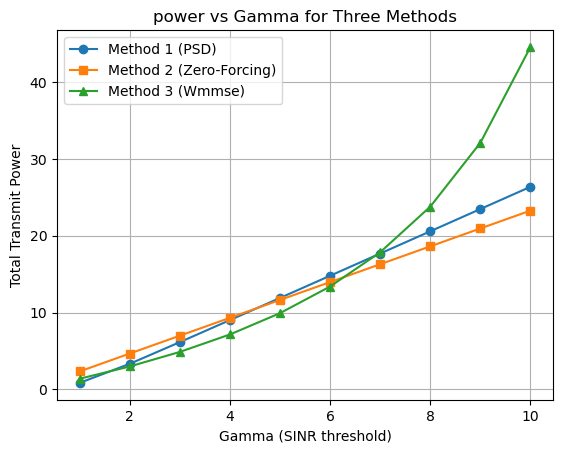

In [4]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters
Ki = 2  # Number of users(ID)
Ke = 1  # Number of users(EH+ID)
Z = 3   # Number of groups
m = 3   # Size of the matrices (e.g., number of antennas)
UserGroup = [0,1,2]
# Random seed for all methods
np.random.seed(1)

# Randomly generate channel vectors, SINR thresholds, and energy demands
gi_vectors = [np.random.randn(m, 1) + 1j * np.random.randn(m, 1) for _ in range(Ki)]  # Ki mx1 complex vectors
ge_vectors = [np.random.randn(m, 1) + 1j * np.random.randn(m, 1) for _ in range(Ke)]  # Ke mx1 complex vectors

# Form the channel matrices
Gi = [gi @ gi.conj().T for gi in gi_vectors]
Ge = [ge @ ge.conj().T for ge in ge_vectors]
xi = 1e-6
sigma_Ri = np.random.rand(Ki)
sigma_Rj = np.random.rand(Ke)
sigma_D = np.random.rand(Ki)
zeta = np.random.rand(Ke)

a = 1500
b = 0.0022
phi = 1/(1 + np.exp(a*b) )
e = 1e-3

# Define a range of gamma values
gamma_values = np.linspace(1, 10, 10)  # 10 values between 0.1 and 1.0
objective_values_method1 = []  # PSD-based optimization
objective_values_zf = []  # Zero-Forcing beamforming
objective_values_wmmse = []    # WMMSE optimization
objective_values_mf = [] # MF
objective_values_mrt = [] # MRT

# -----------------------------------------
# Method 1 (PSD-based optimization)
# -----------------------------------------
for gamma_value in gamma_values:
    # Define the optimization variables (W)
    W = [cp.Variable((m, m), complex=True) for _ in range(Z)]

    # Define the objective function: minimize the total transmit power
    objective = cp.Minimize(cp.real(sum(cp.trace(W_k) for W_k in W)))

    # Define constraints (SINR constraints C1)
    constraints = []
    for i in range(Ki):
        grp = UserGroup[i]
        interference = 0
        for j in range(Z):
            if grp != j:
                interference += cp.real(cp.trace(Gi[i] @ W[j]))
        constraints.append(cp.real(cp.trace(Gi[i] @ W[grp])) - gamma_value * interference >= gamma_value * (sigma_Ri[i] + sigma_D[i]))

    # Energy harvesting constraints (C2)
    for j in range(Ke):
        harvested_energy = cp.real(sum(cp.trace(Ge[j] @ W_k) for W_k in W))
        log_term = np.log(((1 - phi) * (e - xi)) / ((1 - phi) * e + (phi * xi)))
        c = sigma_Rj[j]**2 + b - (log_term / a)
        xi_new = zeta[j] * c
        constraints.append(harvested_energy >= xi_new / zeta[j] - sigma_Rj[j])

    # Positive semi-definite constraint (C3)
    epsilon = 1e-6
    for W_k in W:
        constraints.append(cp.lambda_min(W_k) >= epsilon)

    # Solve the problem for the current gamma value
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Extract the X matrices (diagonal sqrt of W matrices)
    X = [np.sqrt(np.maximum(np.real(np.diag(W[k].value)), 0)) for k in range(Z)]


    # Compute outer products of the X matrices (X_outer)
    X_outer = [np.outer(X_k, X_k) for X_k in X]

    # Calculate the second objective (objective2)
    objective2_value = np.sum([np.trace(X_o) for X_o in X_outer])
    
    # Store the objective2 value for this gamma
    objective_values_method1.append(objective2_value)
# -----------------------------------------
# Method 2 (Zero-Forcing beamforming)
# -----------------------------------------
H = np.hstack(gi_vectors + ge_vectors).conj().T
H_herm = H.conj().T
HHH_inv = np.linalg.inv(H @ H_herm)
W_zf = H_herm @ HHH_inv
w_vectors = [W_zf[:, k:k+1] for k in range(Z)]
W_k_matrices = [w_k @ w_k.conj().T for w_k in w_vectors]

for gamma_value in gamma_values:
    gamma = np.full(Ki, gamma_value)
    p = cp.Variable(Z)
    objective = cp.Minimize(sum(p[k] * cp.real((w_vectors[k].conj().T @ w_vectors[k])[0, 0]) for k in range(Z)))
    constraints = [p[k] >= 1e-6 for k in range(Z)]
    
    # SINR constraints
    for i in range(Ki):
        grp = i
        interference = sum(p[j] * cp.real(cp.trace(Gi[i] @ W_k_matrices[j])) for j in range(Z) if j != grp)
        constraints.append(p[grp] * cp.real(cp.trace(Gi[i] @ W_k_matrices[grp])) - gamma[i] * interference >= gamma[i] * (sigma_Ri[i]**2 + sigma_D[i]**2))

    # Energy harvesting constraints
    for j in range(Ke):
        harvested_energy = sum(p[k] * cp.real(cp.trace(Ge[j] @ W_k_matrices[k])) for k in range(Z))
        log_term = np.log(((1-phi)*(e-xi)) / (1-phi)*e +(phi*xi))
        c = sigma_Rj[j]**2 + b - (log_term / a)
        xi_new = zeta[j] * c
        constraints.append(harvested_energy >= xi_new / zeta[j] - sigma_Rj[j]**2)

    # Power constraints (third constraint)
    '''for k in range(Z):
        den = (w_vectors[k].conj().T @ w_vectors[k])[0, 0]
        constraints.append(p[k] <= 5 / cp.real(den))'''

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status == cp.OPTIMAL:
        objective_values_zf.append(problem.value)
    else:
        objective_values_zf.append(np.nan)

# -----------------------------------------
# Method 3 (Wmmse optimization)
# -----------------------------------------
alpha = 0.3
regularized_term = H @ H_herm + alpha * np.eye(H.shape[0])
regularized_inv = np.linalg.inv(regularized_term)
W_mmse = H_herm @ regularized_inv
w_vectors_wmmse = [W_mmse[:, k:k+1] for k in range(Z)]
W_k_matrices_wmmse = [w_k @ w_k.conj().T for w_k in w_vectors_wmmse]

for gamma_value in gamma_values:
    p = cp.Variable(Z)
    gamma = np.full(Ki, gamma_value)
    objective = cp.Minimize(sum(p[k] * cp.real((w_vectors_wmmse[k].conj().T @ w_vectors_wmmse[k])[0, 0]) for k in range(Z)))
    constraints = [p[k] >= 1e-6 for k in range(Z)]

    # SINR constraints (C1)
    for i in range(Ki):
        grp = i
        interference = sum(p[j] * cp.real(cp.trace(Gi[i] @ W_k_matrices_wmmse[j])) for j in range(Z) if j != grp)
        constraints.append(p[grp] * cp.real(cp.trace(Gi[i] @ W_k_matrices_wmmse[grp])) - gamma[i] * interference >= gamma[i] * (sigma_Ri[i]**2 + sigma_D[i]**2))

    # Energy harvesting constraints
    for j in range(Ke):
        harvested_energy = sum(p[k] * cp.real(cp.trace(Ge[j] @ W_k_matrices_wmmse[k])) for k in range(Z))
        log_term = np.log(((1-phi)*(e-xi)) / (1-phi)*e +(phi*xi))
        c = sigma_Rj[j]**2 + b - (log_term / a)
        xi_new = zeta[j] * c
        constraints.append(harvested_energy >= xi_new / zeta[j] - sigma_Rj[j]**2)

    # Power constraints (third constraint)
    ''' for k in range(Z):
        den = (w_vectors_wmmse[k].conj().T @ w_vectors_wmmse[k])[0, 0]
        constraints.append(p[k] <= 5 / cp.real(den))'''

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status == cp.OPTIMAL:
        objective_values_wmmse.append(problem.value)
    else:
        objective_values_wmmse.append(np.nan)


# -----------------------------------------
# Plot all three methods on the same graph
# -----------------------------------------
plt.plot(gamma_values, objective_values_method1, label="Method 1 (PSD)", marker='o')
plt.plot(gamma_values, objective_values_zf, label="Method 2 (Zero-Forcing)", marker='s')
plt.plot(gamma_values, objective_values_wmmse, label="Method 3 (Wmmse)", marker='^')

plt.xlabel('Gamma (SINR threshold)')
plt.ylabel('Total Transmit Power')
plt.title('power vs Gamma for Three Methods')
plt.grid(True)
plt.legend()
plt.show()